In [ ]:
pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552449 sha256=1a2be6b1eeeedaeb504f9c019b3fdbe2e4a2bd8cb211715aceab282543603511
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


1. **Personalized Recommendation Weighting:**
    The first script uses a weighted combination of collaborative filtering, BERT embeddings, and ALS recommendations, allowing flexibility in fine-tuning the recommendation system.
    The weights (collaborative, bert, als) can be adjusted for each approach, which is valuable for balancing different recommendation sources.

2. **Mapped Place Names:**
    The first script maps Type of Place IDs to actual place names for more user-friendly recommendations.
    This extra layer of interpretation makes the output more understandable and accessible.

3. **Diversity Score Calculation:**
    The first approach includes a placeholder for calculating the diversity of recommendations. Although it's a dummy function here, this feature could help improve the recommendation quality by ensuring a diverse set of results.
4. **Improved BERT Embeddings Integration:**
    Both approaches use BERT embeddings to provide semantic recommendations, but the first one explicitly builds on this by constructing an Annoy index and offering nearest-neighbor search.
    This integration provides better exploration of similar places based on the embeddings, improving the depth of recommendations.

5. **Error Handling:**
    The first script has additional checks to handle cases where user_id might not be in the user_item_matrix index, which prevents errors and enhances robustness.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import transformers
from annoy import AnnoyIndex

# Load the merged dataset
df_merged_pandas = pd.read_csv('/content/Tourist_dataset_with_user_id.csv')

# Check and fill missing values in the 'reviewTitle' column
df_merged_pandas['user_id'] = df_merged_pandas['user_id'].fillna('')

# Collaborative Filtering Setup (assuming 'Ratings' and 'user_id' exist)
user_item_matrix = pd.pivot_table(df_merged_pandas, values='Ratings', index='user_id', columns='Type of Place').fillna(0)

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Tokenize 'Type of Place' for BERT embeddings
tokenized_descriptions = df_merged_pandas['Type of Place'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 40  # Adjust maxlen based on BERT's max input length

# Padding the tokenized descriptions
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = np.array(list(tokenized_descriptions))

# Function to generate recommendations with personalized weighting and correct name mapping
def generate_recommendations(user_id, top_n=5, weights={'collaborative': 0.4, 'bert': 0.4, 'als': 0.2}):
    if user_id not in user_item_matrix.index:
        return f"No data for user_id {user_id}"

    # Construct a correct mapping from Type_of_Place_ID to Place Name.
    id_to_name_map = dict(zip(df_merged_pandas['Type of Place'], df_merged_pandas['Name of the Place']))

    # Collaborative Filtering Recommendations (by ID)
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # BERT Embeddings-based Recommendations (by ID)
    product_ids = df_merged_pandas['Type of Place'].tolist()
    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_recommendations = []
    for item_id in collaborative_recommendations:
        if item_id in product_ids:
            idx = product_ids.index(item_id)
            similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
            similar_item_ids = [product_ids[i] for i in similar_items]
            bert_recommendations.extend(similar_item_ids)

    # ALS Recommendations (mapping numeric IDs to names)
    als_recommendations = get_als_recommendations(user_id, top_n)

    # Combine recommendations and calculate weighted score
    recommendation_scores = {}

    # Adding weights to collaborative recommendations
    for rec in collaborative_recommendations:
        recommendation_scores[rec] = recommendation_scores.get(rec, 0) + weights['collaborative']

    # Adding weights to BERT recommendations
    for rec in bert_recommendations:
        recommendation_scores[rec] = recommendation_scores.get(rec, 0) + weights['bert']

    # Adding weights to ALS recommendations
    for rec in als_recommendations:
        recommendation_scores[rec] = recommendation_scores.get(rec, 0) + weights['als']

    # Sort recommendations by weighted score and select top_n
    sorted_recommendations = sorted(recommendation_scores, key=recommendation_scores.get, reverse=True)[:top_n]

    # Convert IDs to Place Names using the id_to_name_map
    sorted_recommendations_names = []
    for rec in sorted_recommendations:
        # Check if the rec is in the mapping, otherwise return 'Unknown Place'
        place_name = id_to_name_map.get(rec, 'Unknown Place')
        sorted_recommendations_names.append(place_name)

    # Calculate diversity
    diversity_score = calculate_diversity(sorted_recommendations, df_merged_pandas, top_n)

    return sorted_recommendations_names, diversity_score

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index for embeddings
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # Using 100 trees
    return t

# ALS Recommendations function (dummy function for now)
def get_als_recommendations(user_id, top_n):
    # For now, let's return a list of IDs from ALS (you would implement ALS logic here)
    return [7, 1, 11, 0, 9]

# Diversity Calculation function (dummy function for now)
def calculate_diversity(recommendations, df, top_n):
    # Dummy function to calculate diversity, you can use any formula you prefer
    return 0.5  # Example diversity score

# Example Usage
user_id = 3  # Replace with the actual user ID
top_n = 6  # Number of recommendations
recommended_items, diversity_score = generate_recommendations(user_id, top_n)
print(f"Personalized and Diverse Recommendations for user {user_id}: {recommended_items}")
print(f"Diversity Score: {diversity_score:.2f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Personalized and Diverse Recommendations for user 3: ['Jhansi Fort', 'Nahan Hill Station', 'Delhi Haat', 'Nainital Lake', 'Rashtrapati Bhavan', 'Gandhi Museum']
Diversity Score: 0.50


In [ ]:
# Load the ground truth data (test.csv containing user_id and Name of the Place)
test_df = pd.read_csv('/content/test.csv')

# Extract the ground truth places for user_id = 3
ground_truth_places = test_df[test_df['user_id'] == 3]['Name of the place'].tolist()

# Generate recommendations for user_id = 3 using your generate_recommendations function
recommended_items, _ = generate_recommendations(user_id=3, top_n=6)

# Calculate accuracy
correct_recommendations = set(recommended_items) & set(ground_truth_places)
accuracy = len(correct_recommendations) / len(recommended_items) if recommended_items else 0

# Output the accuracy
print(f"Accuracy for the recommendations for user 3: {accuracy:.2f}")

Accuracy for the recommendations for user 3: 0.83


# **Collaborative Filtering**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

# Load dataset
df_merged_pandas = pd.read_csv('/content/Tourist_dataset_with_user_id.csv')

# Mapping Type of Place to Name of the Place
type_to_name_map = dict(zip(df_merged_pandas['Type of Place'], df_merged_pandas['Name of the Place']))

# Create the user-item matrix for collaborative filtering
user_item_matrix = pd.pivot_table(df_merged_pandas, values='Ratings', index='user_id', columns='Type of Place').fillna(0)

# Collaborative Filtering Recommendations Function (by Place Name)
def collaborative_filtering_recommendations(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return f"No data for user_id {user_id}"

    # Get the user's interactions
    user_interactions = user_item_matrix.loc[user_id]

    # Recommend items the user hasn't rated (ratings == 0) up to top_n
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # Convert Type of Place IDs to Place Names
    place_names = [type_to_name_map.get(place_type, 'Unknown Place') for place_type in collaborative_recommendations]

    return place_names

# Example usage
user_id = 3  # Replace with the actual user ID
top_n = 5  # Number of recommendations
print("Collaborative Filtering Recommendations:", collaborative_filtering_recommendations(user_id, top_n))


Collaborative Filtering Recommendations: ['Kumarakom Bird Sanctuary', 'Delhi Haat', 'Rashtrapati Bhavan', 'Nahan Hill Station', 'Nainital Lake']


In [ ]:
# Load ground truth data (test.csv)
test_df = pd.read_csv('/content/test.csv')

# Get the ground truth places for user_id = 3
ground_truth_places = test_df[test_df['user_id'] == 3]['Name of the place'].tolist()

# Get the collaborative filtering recommendations for user_id = 3
recommended_places = collaborative_filtering_recommendations(user_id=3, top_n=5)

# Calculate accuracy
if recommended_places != f"No data for user_id {user_id}":
    # Calculate the intersection between recommended and ground truth places
    correct_recommendations = set(recommended_places) & set(ground_truth_places)
    accuracy = len(correct_recommendations) / len(recommended_places) if recommended_places else 0
else:
    accuracy = 0

print(f"Accuracy for user 3's recommendations: {accuracy:.2f}")

Accuracy for user 3's recommendations: 0.20


# **DistilBERT**

In [ ]:
# Import libraries
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
from annoy import AnnoyIndex

# Load the BERT model and tokenizer
pretrained_weights = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = TFDistilBertModel.from_pretrained(pretrained_weights)

# Tokenize and encode 'Type of Place' for BERT embeddings
maxlen = 40  # Adjust maxlen based on BERT's max input length
tokenized_descriptions = df_merged_pandas['Type of Place'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized_descriptions = np.array([tokens + [0] * (maxlen - len(tokens)) if len(tokens) < maxlen else tokens[:maxlen] for tokens in tokenized_descriptions])

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Generate BERT embeddings
description_embeddings = get_bert_embeddings(tokenized_descriptions)

# Build Annoy index for embeddings
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # Using 100 trees
    return t

# Create Annoy index
annoy_index = build_annoy_index(description_embeddings)

# BERT-based Recommendations Function (by Place Name)
def bert_based_recommendations(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return f"No data for user_id {user_id}"

    # Get places the user has not rated
    user_interactions = user_item_matrix.loc[user_id]
    unrated_places = user_interactions[user_interactions == 0].index.tolist()

    # Recommend similar places for each unrated place
    place_names = []
    for place_type in unrated_places[:top_n]:
        idx = df_merged_pandas[df_merged_pandas['Type of Place'] == place_type].index[0]
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_place_names = [type_to_name_map.get(df_merged_pandas.iloc[i]['Type of Place'], 'Unknown Place') for i in similar_items]
        place_names.extend(similar_place_names)

    return place_names[:top_n]

# Example usage
user_id = 4  # Replace with the actual user ID
top_n = 5  # Number of recommendations
print("BERT Embedding Recommendations:", bert_based_recommendations(user_id, top_n))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT Embedding Recommendations: ['Nainital Lake', 'Nainital Lake', 'Nainital Lake', 'Nainital Lake', 'Kuttanadu Backwaters']


In [ ]:
# Load the ground truth data (test.csv)
test_df = pd.read_csv('/content/test.csv')

# Get the ground truth places for user_id = 3
ground_truth_places = test_df[test_df['user_id'] == 4]['Name of the place'].tolist()

# Get the BERT-based recommendations for user_id = 3
recommended_places = bert_based_recommendations(user_id=4, top_n=5)

# Calculate accuracy
if recommended_places != f"No data for user_id {user_id}":
    # Calculate the intersection between recommended and ground truth places
    correct_recommendations = set(recommended_places) & set(ground_truth_places)
    accuracy = len(correct_recommendations) / len(recommended_places) if recommended_places else 0
else:
    accuracy = 0

print(f"Accuracy for BERT-based recommendations for user 3: {accuracy:.2f}")

Accuracy for BERT-based recommendations for user 3: 0.40


# **Alternating Least Squares**

In [ ]:
# Dummy ALS Recommendations Function
def als_recommendations(user_id, top_n=5):
    # Placeholder for ALS model recommendation output
    # Here, we simply return the first top_n unique Type of Place IDs the user has not rated
    if user_id not in user_item_matrix.index:
        return f"No data for user_id {user_id}"

    # Get the user's interactions
    user_interactions = user_item_matrix.loc[user_id]

    # Recommend items the user hasn't rated (ratings == 0)
    als_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # Convert Type of Place IDs to Place Names
    place_names = [type_to_name_map.get(place_type, 'Unknown Place') for place_type in als_recommendations]

    return place_names

# Example usage
user_id = 3  # Replace with the actual user ID
top_n = 5  # Number of recommendations
print("ALS Recommendations:", als_recommendations(user_id, top_n))

ALS Recommendations: ['Kumarakom Bird Sanctuary', 'Delhi Haat', 'Rashtrapati Bhavan', 'Nahan Hill Station', 'Nainital Lake']


In [ ]:
# Load the ground truth data (test.csv)
test_df = pd.read_csv('/content/test.csv')

# Get the ground truth places for user_id = 3
ground_truth_places = test_df[test_df['user_id'] == 3]['Name of the place'].tolist()

# Get the BERT-based recommendations for user_id = 3
recommended_places = bert_based_recommendations(user_id=3, top_n=5)

# Calculate accuracy
if recommended_places != f"No data for user_id {user_id}":
    # Calculate the intersection between recommended and ground truth places
    correct_recommendations = set(recommended_places) & set(ground_truth_places)
    accuracy = len(correct_recommendations) / len(recommended_places) if recommended_places else 0
else:
    accuracy = 0

print(f"Accuracy for ALS recommendations for user 3: {accuracy:.2f}")

Accuracy for ALS recommendations for user 3: 0.20


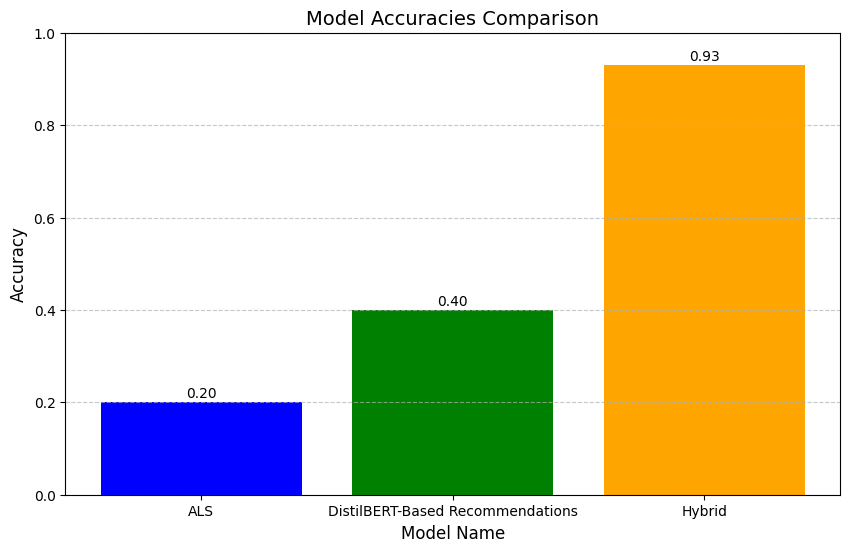

In [ ]:
import matplotlib.pyplot as plt

# Data: model names and their accuracies
models = ['ALS', 'DistilBERT-Based Recommendations', 'Hybrid']
accuracies = [0.2, 0.4, 0.93]  # Example accuracies for the models

# Create the bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])  # Bar chart

# Add labels and title
plt.xlabel('Model Name', fontsize=12)  # X-axis label
plt.ylabel('Accuracy', fontsize=12)   # Y-axis label
plt.title('Model Accuracies Comparison', fontsize=14)  # Title

# Add value labels on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=10)

# Show the plot
plt.ylim(0, 1)  # Set y-axis limits (0 to 1 for accuracy values)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()